In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('All libraries have been imported.')

All libraries have been imported.


In [2]:

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'VHANTCGXBCUGPZS1TD3BODZDG1WJ2IRKHQWFTNKA3IDXMG5N' # your Foursquare ID
    CLIENT_SECRET = 'IRPBYYKC3VOGMU1RMZKEWZDHNLEDXN1WP5UNHFN3NK4XTGA0' # your Foursquare Secret
    VERSION = '20200713' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'VHANTCGXBCUGPZS1TD3BODZDG1WJ2IRKHQWFTNKA3IDXMG5N' # your Foursquare ID
    CLIENT_SECRET = 'IRPBYYKC3VOGMU1RMZKEWZDHNLEDXN1WP5UNHFN3NK4XTGA0' # your Foursquare Secret
    VERSION = '20200713' # Foursquare API version
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:
new_york_data.shape

(306, 4)

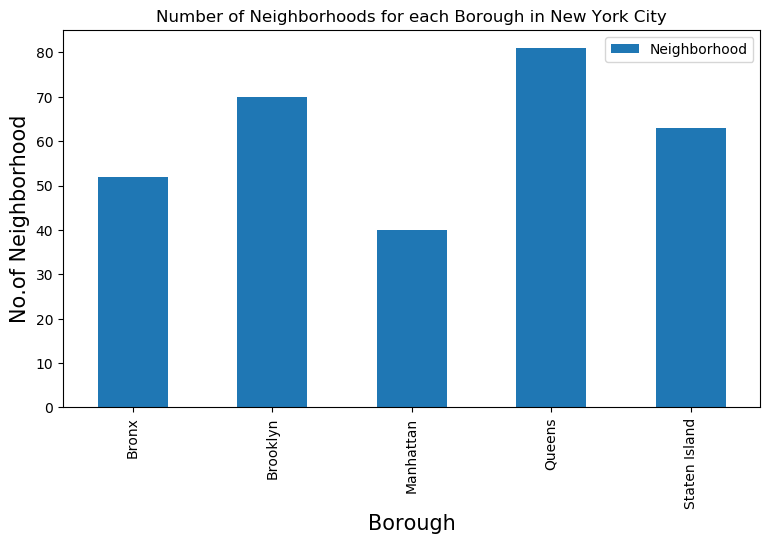

In [10]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [11]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    for restaurant_detail in indian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Indian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Indian Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Restaurants in City Island, Bronx:0
( 14 / 306 ) Indian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Indian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Indian Restaurants in East Tremont, Bronx:

In [12]:
indian_rest_ny.head()

Borough    Neighborhood                        ID  \
0   Bronx        Woodlawn  4c0448d9310fc9b6bf1dc761   
1   Bronx     Parkchester  4c194631838020a13e78e561   
2   Bronx  Spuyten Duyvil  4c04544df423a593ac83d116   
3   Bronx       Concourse  551b7f75498e86c00a0ed2e1   
4   Bronx       Unionport  4c194631838020a13e78e561   

                          Name  
0                   Curry Spot  
1  Melanies Roti Bar And Grill  
2         Cumin Indian Cuisine  
3                  Hungry Bird  
4  Melanies Roti Bar And Grill

In [14]:
indian_rest_ny

Borough               Neighborhood                        ID  \
0            Bronx                   Woodlawn  4c0448d9310fc9b6bf1dc761   
1            Bronx                Parkchester  4c194631838020a13e78e561   
2            Bronx             Spuyten Duyvil  4c04544df423a593ac83d116   
3            Bronx                  Concourse  551b7f75498e86c00a0ed2e1   
4            Bronx                  Unionport  4c194631838020a13e78e561   
5            Bronx                  Unionport  55dfa36a498e164ef19bef7b   
6         Brooklyn                  Bay Ridge  4b5a4dc8f964a520a2bb28e3   
7         Brooklyn                  Bay Ridge  545835a1498e820edc6f636f   
8         Brooklyn             Brighton Beach  4af0d31bf964a5207ddf21e3   
9         Brooklyn                   Flatbush  52213c4211d295d4c57a607c   
10        Brooklyn                   Flatbush  564d283d498e6e851df79d87   
11        Brooklyn              East Flatbush  512a9ea9e4b004fb8eeb84e5   
12        Brooklyn                 Kensington  4db0f4371e729fcc56497f20   
13        Brooklyn                 Kensington  4b718914f964a520c04b2de3   
14        Brooklyn                Fort Greene  57596dad498e732300496b23   
15        Brooklyn               Clinton Hill  57596dad498e732300496b23   
16        Brooklyn               Clinton Hill  568d3902498e619efcbc3f58   
17        Brooklyn                Boerum Hill  543870ec498ec64de510608d   
18        Brooklyn  Prospect Lefferts Gardens  4bb93b70cf2fc9b6fe64a002   
19        Brooklyn                 Ocean Hill  5539753f498edbace4746b67   
20        Brooklyn                 Ocean Hill  4f6cae2ee4b0d4a5afcef5c0   
21        Brooklyn        Prospect Park South  519ff6c8498e1300ddcbd45c   
22        Brooklyn        Prospect Park South  4db0f4371e729fcc56497f20   
23        Brooklyn          East Williamsburg  5514551f498e89f59ce53e5a   
24        Brooklyn                 South Side  5631511b498e3d6d7e0a4df0   
25        Brooklyn              Fort Hamilton  545835a1498e820edc6f636f   
26       Manhattan         Washington Heights  4ae7876ef964a5201eac21e3   
27       Manhattan           Hamilton Heights  54c2bd96498eaf5142e3fe92   
28       Manhattan           Hamilton Heights  5914ff32b23dfa207eca38de   
29       Manhattan             Manhattanville  529d382a11d2dd5ef107e641   
30       Manhattan             Manhattanville  54c2bd96498eaf5142e3fe92   
31       Manhattan             Central Harlem  56d87f3d498ee215abee5724   
32       Manhattan             Central Harlem  54c2bd96498eaf5142e3fe92   
33       Manhattan                East Harlem  519fe6f5498e30595d370c44   
34       Manhattan                  Yorkville  5272ca4511d22488f6895caf   
35       Manhattan                  Yorkville  56ed855a498ef3bb022352c3   
36       Manhattan           Roosevelt Island  4fe4fb50c2eee335e4fea69d   
37       Manhattan            Upper West Side  42489a80f964a5208b201fe3   
38       Manhattan            Upper West Side  591890f43abcaf1ddca66e85   
39       Manhattan                    Chelsea  4b4aab62f964a520978c26e3   
40       Manhattan                    Tribeca  4bbb9dbded7776b0e1ad3e51   
41       Manhattan               West Village  5803c0db38fa71491b748a7d   
42       Manhattan               West Village  591794df2be42556988e4a8e   
43       Manhattan           Manhattan Valley  49c5ad0af964a5201b571fe3   
44       Manhattan           Manhattan Valley  538ba1f2498e279098e4210a   
45       Manhattan           Manhattan Valley  424de080f964a520ae201fe3   
46       Manhattan        Morningside Heights  49c5ad0af964a5201b571fe3   
47       Manhattan                   Gramercy  4a70a75bf964a52016d81fe3   
48       Manhattan                   Gramercy  57f7cbbe498edf8f07c7ba83   
49       Manhattan                   Gramercy  523b2b42498e1dfabcc8ab15   
50       Manhattan                   Gramercy  43d537d0f964a520402e1fe3   
51       Manhattan                   Gramercy  4a12eb1ff964a52099771fe3   
52          Queens                  

In [15]:
indian_rest_ny.shape

(141, 4)

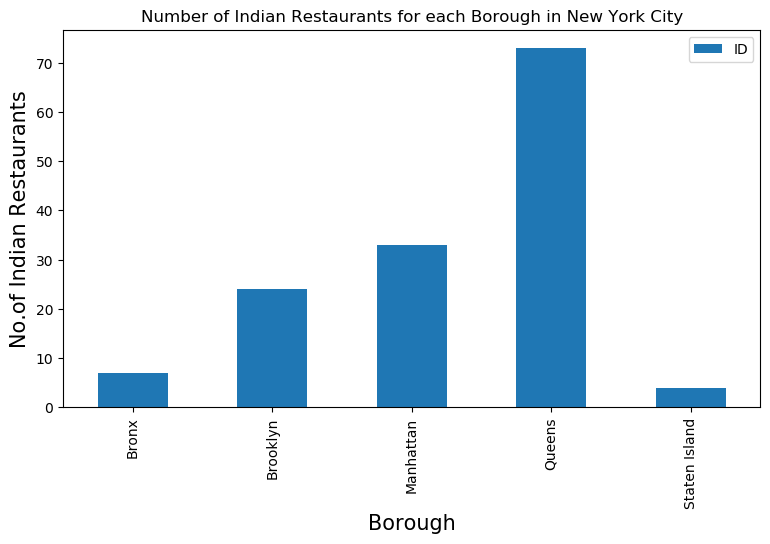

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

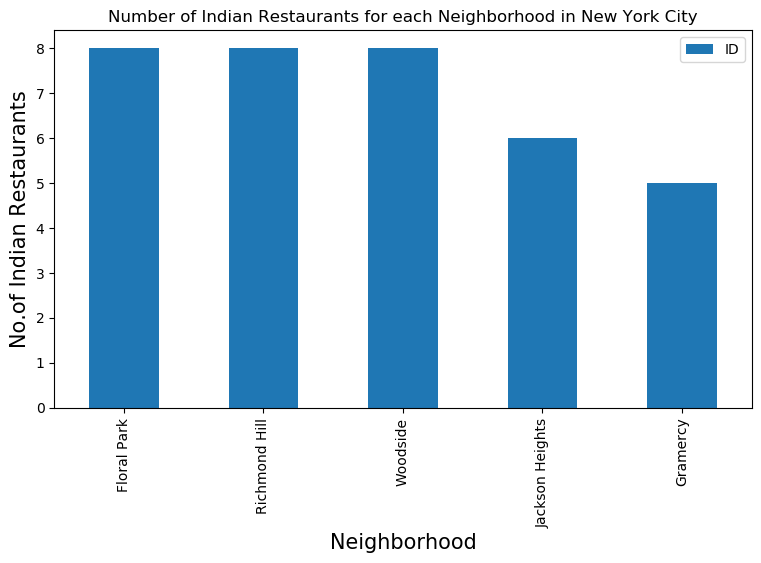

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [18]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

Borough Neighborhood                        ID                       Name
105  Queens  Floral Park  527ffc0811d2d329d5e49abd              Jackson Diner
106  Queens  Floral Park  4e4e3e22bd4101d0d7a5c2d1             Kerala Kitchen
107  Queens  Floral Park  4b647b56f964a520c4b62ae3   Usha Foods & Usha Sweets
108  Queens  Floral Park  4b787c49f964a5209cd12ee3  Santoor Indian Restaurant
109  Queens  Floral Park  4c0c01e0bbc676b00d6b4cd5              Mumbai Xpress
110  Queens  Floral Park  4c76ff35a5676dcb72671721            Flavor Of India
111  Queens  Floral Park  4df0f39dd4c04d0392c853ea              Sagar Chinese
112  Queens  Floral Park  4e6bfe1c7d8b2c711b17bbe5    Surya sweets and snacks

In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have 
        #recently opened or details do not exist in the FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.1    10
( 1 / 141 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 2 / 141 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 141 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 141 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 5 / 141 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 141 ) processed
                         ID       Name  Likes  Rat

In [20]:
indian_rest_stats_ny.head()

Borough    Neighborhood                        ID  \
0   Bronx        Woodlawn  4c0448d9310fc9b6bf1dc761   
1   Bronx     Parkchester  4c194631838020a13e78e561   
2   Bronx  Spuyten Duyvil  4c04544df423a593ac83d116   
3   Bronx       Concourse  551b7f75498e86c00a0ed2e1   
4   Bronx       Unionport  4c194631838020a13e78e561   

                          Name Likes  Rating Tips  
0                   Curry Spot     5     8.1   10  
1  Melanies Roti Bar And Grill     3     5.9    2  
2         Cumin Indian Cuisine    13     5.9    9  
3                  Hungry Bird     8     6.7    3  
4  Melanies Roti Bar And Grill     3     5.9    2

In [21]:
indian_rest_stats_ny.shape

(141, 7)

In [22]:
indian_rest_ny.shape

(141, 4)

In [23]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [24]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [25]:
indian_rest_stats_ny_csv.shape

(141, 7)

In [26]:
indian_rest_stats_ny_csv.head()

Borough    Neighborhood                        ID  \
0   Bronx        Woodlawn  4c0448d9310fc9b6bf1dc761   
1   Bronx     Parkchester  4c194631838020a13e78e561   
2   Bronx  Spuyten Duyvil  4c04544df423a593ac83d116   
3   Bronx       Concourse  551b7f75498e86c00a0ed2e1   
4   Bronx       Unionport  4c194631838020a13e78e561   

                          Name  Likes  Rating  Tips  
0                   Curry Spot      5     8.1    10  
1  Melanies Roti Bar And Grill      3     5.9     2  
2         Cumin Indian Cuisine     13     5.9     9  
3                  Hungry Bird      8     6.7     3  
4  Melanies Roti Bar And Grill      3     5.9     2

In [27]:
indian_rest_stats_ny_csv

Borough               Neighborhood                        ID  \
0            Bronx                   Woodlawn  4c0448d9310fc9b6bf1dc761   
1            Bronx                Parkchester  4c194631838020a13e78e561   
2            Bronx             Spuyten Duyvil  4c04544df423a593ac83d116   
3            Bronx                  Concourse  551b7f75498e86c00a0ed2e1   
4            Bronx                  Unionport  4c194631838020a13e78e561   
5            Bronx                  Unionport                         0   
6         Brooklyn                  Bay Ridge  4b5a4dc8f964a520a2bb28e3   
7         Brooklyn                  Bay Ridge  545835a1498e820edc6f636f   
8         Brooklyn             Brighton Beach  4af0d31bf964a5207ddf21e3   
9         Brooklyn                   Flatbush  52213c4211d295d4c57a607c   
10        Brooklyn                   Flatbush  564d283d498e6e851df79d87   
11        Brooklyn              East Flatbush  512a9ea9e4b004fb8eeb84e5   
12        Brooklyn                 Kensington  4db0f4371e729fcc56497f20   
13        Brooklyn                 Kensington  4b718914f964a520c04b2de3   
14        Brooklyn                Fort Greene  57596dad498e732300496b23   
15        Brooklyn               Clinton Hill  57596dad498e732300496b23   
16        Brooklyn               Clinton Hill  568d3902498e619efcbc3f58   
17        Brooklyn                Boerum Hill  543870ec498ec64de510608d   
18        Brooklyn  Prospect Lefferts Gardens  4bb93b70cf2fc9b6fe64a002   
19        Brooklyn                 Ocean Hill  5539753f498edbace4746b67   
20        Brooklyn                 Ocean Hill  4f6cae2ee4b0d4a5afcef5c0   
21        Brooklyn        Prospect Park South  519ff6c8498e1300ddcbd45c   
22        Brooklyn        Prospect Park South  4db0f4371e729fcc56497f20   
23        Brooklyn          East Williamsburg  5514551f498e89f59ce53e5a   
24        Brooklyn                 South Side  5631511b498e3d6d7e0a4df0   
25        Brooklyn              Fort Hamilton  545835a1498e820edc6f636f   
26       Manhattan         Washington Heights  4ae7876ef964a5201eac21e3   
27       Manhattan           Hamilton Heights  54c2bd96498eaf5142e3fe92   
28       Manhattan           Hamilton Heights  5914ff32b23dfa207eca38de   
29       Manhattan             Manhattanville  529d382a11d2dd5ef107e641   
30       Manhattan             Manhattanville  54c2bd96498eaf5142e3fe92   
31       Manhattan             Central Harlem  56d87f3d498ee215abee5724   
32       Manhattan             Central Harlem  54c2bd96498eaf5142e3fe92   
33       Manhattan                East Harlem  519fe6f5498e30595d370c44   
34       Manhattan                  Yorkville  5272ca4511d22488f6895caf   
35       Manhattan                  Yorkville  56ed855a498ef3bb022352c3   
36       Manhattan           Roosevelt Island  4fe4fb50c2eee335e4fea69d   
37       Manhattan            Upper West Side  42489a80f964a5208b201fe3   
38       Manhattan            Upper West Side  591890f43abcaf1ddca66e85   
39       Manhattan                    Chelsea  4b4aab62f964a520978c26e3   
40       Manhattan                    Tribeca  4bbb9dbded7776b0e1ad3e51   
41       Manhattan               West Village  5803c0db38fa71491b748a7d   
42       Manhattan               West Village  591794df2be42556988e4a8e   
43       Manhattan           Manhattan Valley  49c5ad0af964a5201b571fe3   
44       Manhattan           Manhattan Valley  538ba1f2498e279098e4210a   
45       Manhattan           Manhattan Valley  424de080f964a520ae201fe3   
46       Manhattan        Morningside Heights  49c5ad0af964a5201b571fe3   
47       Manhattan                   Gramercy  4a70a75bf964a52016d81fe3   
48       Manhattan                   Gramercy  57f7cbbe498edf8f07c7ba83   
49       Manhattan                   Gramercy  523b2b42498e1dfabcc8ab15   
50       Manhattan                   Gramercy  43d537d0f964a520402e1fe3   
51       Manhattan                   Gramercy  4a12eb1ff964a52099771fe3   
52          Queens                  

In [28]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       141 non-null    object 
 1   Neighborhood  141 non-null    object 
 2   ID            141 non-null    object 
 3   Name          141 non-null    object 
 4   Likes         141 non-null    object 
 5   Rating        141 non-null    float64
 6   Tips          141 non-null    object 
dtypes: float64(1), object(6)
memory usage: 4.5+ KB


In [29]:

indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [30]:

indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [31]:

indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [32]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       141 non-null    object 
 1   Neighborhood  141 non-null    object 
 2   ID            141 non-null    object 
 3   Name          141 non-null    object 
 4   Likes         141 non-null    float64
 5   Rating        141 non-null    float64
 6   Tips          141 non-null    float64
dtypes: float64(3), object(4)
memory usage: 5.6+ KB


In [33]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                589
Rating                                 9
Tips                                 148
Name: 40, dtype: object

In [34]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood            Long Island City
ID              5b931ea69d7468002c3b1382
Name                                Adda
Likes                                129
Rating                               9.1
Tips                                  35
Name: 83, dtype: object

In [35]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                496
Rating                               8.2
Tips                                 164
Name: 51, dtype: object

In [36]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [39]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

Neighborhood  Average Rating
4     Blissville             9.1
59     Sunnyside             9.1
63       Tribeca             9.0
12  Civic Center             9.0
24   Fort Greene             8.8

In [40]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [41]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2      Manhattan        8.278788
4  Staten Island        7.950000
1       Brooklyn        7.745833
3         Queens        6.791781
0          Bronx        5.600000

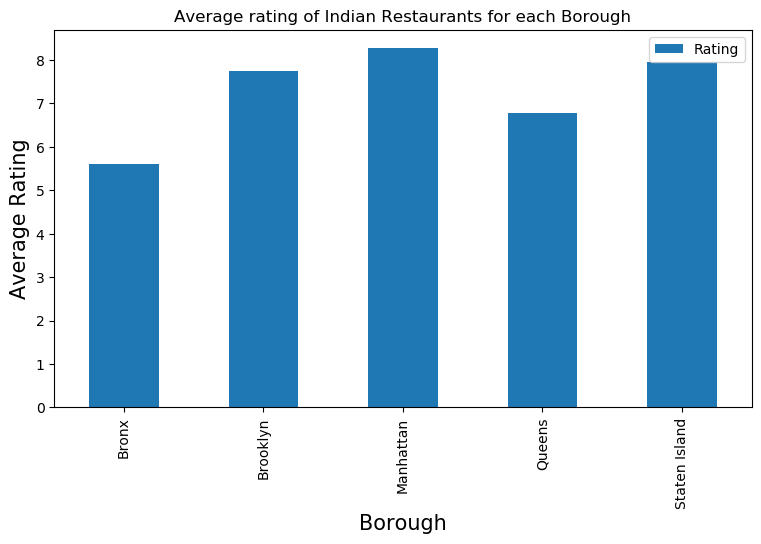

In [42]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [43]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.5]
ny_neighborhood_stats

Neighborhood  Average Rating
0                     Astoria        8.433333
1                   Bay Ridge        7.700000
2                     Bayside        7.600000
4                  Blissville        9.100000
5                 Boerum Hill        8.000000
8           Broadway Junction        8.100000
9               Carnegie Hill        8.400000
10             Central Harlem        8.150000
11                    Chelsea        8.700000
12               Civic Center        9.000000
13               Clinton Hill        8.350000
16                Ditmas Park        7.900000
17              East Flatbush        8.000000
18                East Harlem        7.500000
19          East Williamsburg        7.700000
20                   Elmhurst        8.025000
24                Fort Greene        8.800000
27                   Gramercy        8.440000
28                 Grant City        8.200000
29           Hamilton Heights        7.650000
30                 Holliswood        8.500000
31            Jackson Heights        8.100000
36                Kew Gardens        7.950000
38           Long Island City        8.250000
39           Manhattan Valley        7.966667
40             Manhattanville        7.800000
41        Morningside Heights        8.200000
42               New Brighton        7.700000
43                   New Dorp        8.200000
44                       Noho        8.700000
45                 Ocean Hill        8.100000
47  Prospect Lefferts Gardens        8.700000
48        Prospect Park South        7.900000
50                 Ravenswood        8.100000
51                  Rego Park        7.500000
53                  Ridgewood        8.400000
54           Roosevelt Island        8.300000
56                 South Side        8.200000
58                   Steinway        8.500000
59                  Sunnyside        9.100000
60          Sunnyside Gardens        7.700000
61               Sutton Place        8.300000
62              Tompkinsville        7.700000
63                    Tribeca        9.000000
64                 Turtle Bay        8.100000
66            Upper West Side        8.500000
67         Washington Heights        8.000000
68               West Village        8.700000
69                   Woodlawn        8.100000
70                   Woodside        7.875000
71                  Yorkville        8.400000

In [44]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Borough               Neighborhood   Latitude  Longitude  \
0          Queens                    Astoria  40.768509 -73.915654   
1        Brooklyn                  Bay Ridge  40.625801 -74.030621   
2          Queens                    Bayside  40.766041 -73.774274   
3          Queens                 Blissville  40.737251 -73.932442   
4        Brooklyn                Boerum Hill  40.685683 -73.983748   
5        Brooklyn          Broadway Junction  40.677861 -73.903317   
6       Manhattan              Carnegie Hill  40.782683 -73.953256   
7       Manhattan             Central Harlem  40.815976 -73.943211   
8       Manhattan                    Chelsea  40.744035 -74.003116   
9   Staten Island                    Chelsea  40.594726 -74.189560   
10      Manhattan               Civic Center  40.715229 -74.005415   
11       Brooklyn               Clinton Hill  40.693229 -73.967843   
12       Brooklyn                Ditmas Park  40.643675 -73.961013   
13       Brooklyn              East Flatbush  40.641718 -73.936103   
14      Manhattan                East Harlem  40.792249 -73.944182   
15       Brooklyn          East Williamsburg  40.708492 -73.938858   
16         Queens                   Elmhurst  40.744049 -73.881656   
17       Brooklyn                Fort Greene  40.688527 -73.972906   
18      Manhattan                   Gramercy  40.737210 -73.981376   
19  Staten Island                 Grant City  40.576216 -74.105856   
20      Manhattan           Hamilton Heights  40.823604 -73.949688   
21         Queens                 Holliswood  40.720957 -73.767142   
22         Queens            Jackson Heights  40.751981 -73.882821   
23         Queens                Kew Gardens  40.705179 -73.829819   
24         Queens           Long Island City  40.750217 -73.939202   
25      Manhattan           Manhattan Valley  40.797307 -73.964286   
26      Manhattan             Manhattanville  40.816934 -73.957385   
27      Manhattan        Morningside Heights  40.808000 -73.963896   
28  Staten Island               New Brighton  40.640615 -74.087017   
29  Staten Island                   New Dorp  40.572572 -74.116479   
30      Manhattan                       Noho  40.723259 -73.988434   
31       Brooklyn                 Ocean Hill  40.678403 -73.913068   
32       Brooklyn  Prospect Lefferts Gardens  40.658420 -73.954899   
33       Brooklyn        Prospect Park South  40.647009 -73.962613   
34         Queens                 Ravenswood  40.761705 -73.931575   
35         Queens                  Rego Park  40.728974 -73.857827   
36         Queens                  Ridgewood  40.708323 -73.901435   
37      Manhattan           Roosevelt Island  40.762160 -73.949168   
38       Brooklyn                 South Side  40.710861 -73.958001   
39         Queens                   Steinway  40.775923 -73.902290   
40         Queens                  Sunnyside  40.740176 -73.926916   
41  Staten Island                  Sunnyside  40.612760 -74.097126   
42         Queens          Sunnyside Gardens  40.745652 -73.918193   
43      Manhattan               Sutton Place  40.760280 -73.963556   
44  Staten Island              Tompkinsville  40.637316 -74.080554   
45      Manhattan                    Tribeca  40.721522 -74.010683   
46      Manhattan                 Turtle Bay  40.752042 -73.967708   
47      Manhattan            Upper West Side  40.787658 -73.977059   
48      Manhattan         Washington Heights  40.851903 -73.936900   
49      Manhattan               West Village  40.734434 -74.006180   
50          Bronx                   Woodlawn  40.898273 -73.867315   
51         Queens                   Woodside  40.746349 -73.901842   
52      Manhattan                  Yorkville  40.775930 -73.947118   

    Average Rating  
0         8.433333  
1         7.700000  
2         7.600000  
3         9.100000  
4         8.000000  
5         8.100000  
6         8.400000  
7         8.150000  
8         8.700000  
9         8.700000 

In [45]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [46]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [47]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'
ny_map.choropleth (
    geo_data=ny_geo,
    name='choropleth',
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)


ny_map

C:\Users\saika\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
